In [1]:
import numpy as np
import datetime
from netCDF4 import Dataset
import itertools
import matplotlib.pyplot as plt
from matplotlib import gridspec
import tqdm
from scipy.stats import linregress
import warnings
warnings.filterwarnings("ignore")

In [2]:
# create days and dates list from 01/10/2010 - 30/04/2011
days_short = np.arange(0,212)
dates_short = [datetime.date(2010,10,1)+datetime.timedelta(days=np.int(days)) for days in days_short]
doys_short = np.array([x.timetuple().tm_yday for x in dates_short])
# create days and dates list from 01/01/2010 - 30/04/2021
days_long = np.arange(0,4138)
dates_long = [datetime.date(2010,1,1)+datetime.timedelta(days=np.int(days)) for days in days_long]
doys_long = np.array([x.timetuple().tm_yday for x in dates_long])

### load buoy data and create buoy climatology

In [3]:
datapath = '/Users/carmennab/Dropbox/alpha_retracker/data/validation/BGEP/'
bgep_a = np.asarray(Dataset(datapath+'ULS_A/SIT_EASE_01Jan2010-31Jul2021.nc')['Sea Ice Thickness'])[:4138]
bgep_b = np.asarray(Dataset(datapath+'ULS_B/SIT_EASE_01Jan2010-31Jul2021.nc')['Sea Ice Thickness'])[:4138]
bgep_d = np.asarray(Dataset(datapath+'ULS_D/SIT_EASE_01Jan2010-31Jul2021.nc')['Sea Ice Thickness'])[:4138]

In [4]:
days = np.arange(0,367)
buoya_avs = np.array([np.nanmean(bgep_a[doys_long==day]) for day in days])
buoyb_avs = np.array([np.nanmean(bgep_b[doys_long==day]) for day in days])
buoyd_avs = np.array([np.nanmean(bgep_d[doys_long==day]) for day in days])

buoy_clims = np.array([buoya_avs,buoyb_avs,buoyd_avs])
buoy_clim = np.nanmean(buoy_clims,axis=0) ### climatology

buoy_meanss = np.array([bgep_a,bgep_b,bgep_d])
buoy_means = np.nanmean(buoy_meanss,axis=0)  
buoy_anoms = np.array([buoy-buoy_clim[doy] for doy,buoy in zip(doys_long,buoy_means)])

### calculate optimal alpha over FYI / MYI

In [5]:
datapath = '/Users/carmennab/Dropbox/alpha_retracker/data/icetype/'
it_a = np.array(Dataset(datapath + 'ULS_A.nc')['Ice Type'])
it_b = np.array(Dataset(datapath + 'ULS_B.nc')['Ice Type'])
it_d = np.array(Dataset(datapath + 'ULS_D.nc')['Ice Type'])
icetype = np.nanmean(np.array([it_a,it_b,it_d]),axis = 0)

icetype[icetype<2.5] = 2 # fyi
icetype[icetype>=2.5] = 3 # myi

In [6]:
fyi_buoys = buoy_anoms.copy()
fyi_buoys[icetype == 3] = np.nan # remove myi
fyi_buoys[np.isnan(icetype)] = np.nan

myi_buoys = buoy_anoms.copy()
myi_buoys[icetype == 2] = np.nan # remove fyi
myi_buoys[np.isnan(icetype)] = np.nan

### calculate optimal alpha at different temperatures

In [7]:
datapath = '/Users/carmennab/Dropbox/alpha_retracker/data/temperature/'
temp_a = np.array(Dataset(datapath + 'ERA5_temp_ULS_A.nc')['Air Temperature'])
temp_b = np.array(Dataset(datapath + 'ERA5_temp_ULS_B.nc')['Air Temperature'])
temp_d = np.array(Dataset(datapath + 'ERA5_temp_ULS_D.nc')['Air Temperature'])
temps = np.nanmean(np.array([temp_a,temp_b,temp_d]),axis = 0)

q = np.quantile(temps.ravel()[~np.isnan(temps.ravel())],q=np.arange(0,1.01,0.333333))

In [8]:
icetype_anoms = [fyi_buoys,myi_buoys]
it_names = ['FYI','MYI']
hot_results = {} ; warm_results = {} ; cold_results = {} ; 
ns = []

for it_name,icetype_anom in zip(it_names,icetype_anoms):
    
    cold_buoys = icetype_anom.copy()
    cold_buoys[temps >= q[1]] = np.nan 
    cold_buoys[temps < q[0]] = np.nan 
    cold_buoys[np.isnan(temps)] = np.nan
    ns.append(cold_buoys[~np.isnan(cold_buoys)].shape[0])

    warm_buoys = icetype_anom.copy()
    warm_buoys[temps>= q[2]] = np.nan 
    warm_buoys[temps< q[1]] = np.nan 
    warm_buoys[np.isnan(temps)] = np.nan
    ns.append(warm_buoys[~np.isnan(warm_buoys)].shape[0])
    
    hot_buoys = icetype_anom.copy()
    hot_buoys[temps > q[3]] = np.nan
    hot_buoys[temps < q[2]] = np.nan 
    hot_buoys[np.isnan(temps)] = np.nan
    ns.append(hot_buoys[~np.isnan(hot_buoys)].shape[0])

    datapath = '/Users/carmennab/Dropbox/alpha_retracker/data/sit/'
    names = ['CPOM','AWI']
    alphas = np.arange(0,101)
    all_hot = {}
    all_warm = {}
    all_cold = {}

    for name in names:
        rs_hot = np.full(101,np.nan)
        rs_warm = np.full(101,np.nan)
        rs_cold = np.full(101,np.nan)
        for alpha in alphas:
            a = np.asarray(Dataset(datapath+'SMLG_'+name+'/ULS_A/a'+str(alpha)+'.nc')['Sea Ice Thickness'])
            b = np.asarray(Dataset(datapath+'SMLG_'+name+'/ULS_B/a'+str(alpha)+'.nc')['Sea Ice Thickness'])
            d = np.asarray(Dataset(datapath+'SMLG_'+name+'/ULS_D/a'+str(alpha)+'.nc')['Sea Ice Thickness'])

            ### create daily climatology for cs2
            cs2a_avs = np.array([np.nanmean(a[doys_long==day]) for day in days])
            cs2b_avs = np.array([np.nanmean(b[doys_long==day]) for day in days])
            cs2d_avs = np.array([np.nanmean(d[doys_long==day]) for day in days])

            cs2_clims = np.array([cs2a_avs,cs2b_avs,cs2d_avs])
            cs2_clim = np.nanmean(cs2_clims,axis=0) ### climatology

            cs2_meanss = np.array([a,b,d])
            cs2_means = np.nanmean(cs2_meanss,axis=0) ### giant cs2 data  

            ### create daily anomalies for cs2
            cs2_anoms = np.array([cs2-cs2_clim[doy] for doy,cs2 in zip(doys_long,cs2_means)]) 

            ### calculate alpha hot:  temps => -10 degrees
            mask_hot = ~np.isnan(hot_buoys) & ~np.isnan(cs2_anoms) 
            rstats = linregress(hot_buoys[mask_hot],cs2_anoms[mask_hot]) 
            p = rstats.pvalue
            if p <=0.05:
                rs_hot[alpha] = rstats.rvalue

            ### calculate alpha warm: -10 > temps => -20 degrees
            mask_warm = ~np.isnan(warm_buoys) & ~np.isnan(cs2_anoms)
            rstats = linregress(warm_buoys[mask_warm],cs2_anoms[mask_warm]) 
            p = rstats.pvalue
            if p <=0.05:
                rs_warm[alpha] = rstats.rvalue

            ### calculate alpha cold: temps < -20 degrees
            mask_cold = ~np.isnan(cold_buoys) & ~np.isnan(cs2_anoms)
            rstats = linregress(cold_buoys[mask_cold],cs2_anoms[mask_cold]) 
            p = rstats.pvalue
            if p <=0.05:
                rs_cold[alpha] = rstats.rvalue
                
        rs_hot[rs_hot<0] = np.nan
        rs_warm[rs_warm<0] = np.nan
        rs_cold[rs_cold<0] = np.nan

        all_hot[name] = rs_hot
        all_warm[name] = rs_warm
        all_cold[name] = rs_cold
        
    hot_results[it_name] = all_hot
    warm_results[it_name] = all_warm
    cold_results[it_name] = all_cold

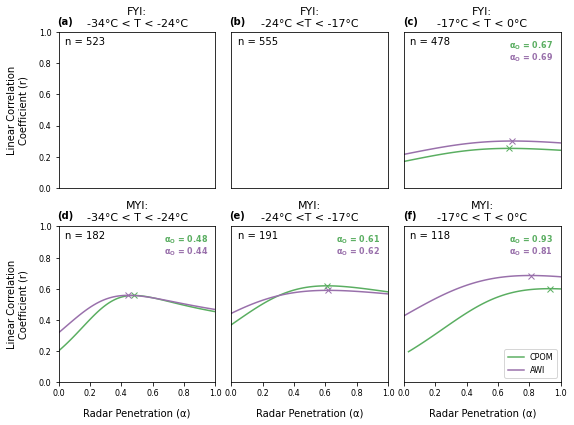

In [9]:
fig = plt.figure(figsize=(9,10))
plt.rcParams.update({'mathtext.default':  'regular' })
plt.rc('font', size=8)
spec = gridspec.GridSpec(ncols=3, nrows=3, wspace=0.1, hspace=0.25)
rs = [cold_results['FYI'],warm_results['FYI'],hot_results['FYI'],cold_results['MYI'],
      warm_results['MYI'],hot_results['MYI']]
labels = ['FYI:\n-34\u00B0C < T < -24\u00B0C','FYI:\n-24\u00B0C <T < -17\u00B0C','FYI:\n-17\u00B0C < T < 0\u00B0C',
          'MYI:\n-34\u00B0C < T < -24\u00B0C','MYI:\n-24\u00B0C <T < -17\u00B0C','MYI:\n-17\u00B0C < T < 0\u00B0C']
nums = ['(a)','(b)','(c)','(d)','(e)','(f)']

for c,r in enumerate(rs):

    ax = plt.subplot(spec[c])

    if ~np.isnan(r['CPOM']).all():
        ax.plot(alphas/100, r['CPOM'],label = 'CPOM',color='#5aae61')
        ax.plot((np.nanargmax(r['CPOM'])/100),np.nanmax(r['CPOM']),'x',color='#5aae61')
        ax.text(0.81, 0.9, f"\u03B1$_O$ = {(np.nanargmax(r['CPOM'])/100):.2f}", ha='center',color='#5aae61',
                weight='bold',transform = ax.transAxes) 
    if ~np.isnan(r['AWI']).all():  
        ax.plot(alphas/100, r['AWI'],label = 'AWI',color='#9970ab')
        ax.plot((np.nanargmax(r['AWI'])/100),np.nanmax(r['AWI']),'x',color='#9970ab')
        ax.text(0.81, 0.82, f"\u03B1$_O$ = {(np.nanargmax(r['AWI'])/100):.2f}", ha='center',color='#9970ab',
                weight='bold',transform = ax.transAxes)
    ax.text(0.04, 1.05,nums[c], ha='center',color='k',weight='bold',transform = ax.transAxes,fontsize=10)
    ax.text(0.17, 0.92,f"n = {ns[c]}", ha='center',color='k',transform = ax.transAxes,fontsize=10)
    ax.set_xlim([0,1])

    ax.set_title(labels[c],fontsize=11)
    
    if c <3:
        ax.set_xticks([])
    if c in [1,2,4,5]:
        ax.set_yticks([])
    if c in [3,4,5]:
        ax.set_xlabel('Radar Penetration (\u03B1)',labelpad=10,fontsize=10)
    ax.set_ylim([0,1])
    if c in [0,3]:
        ax.set_ylabel('Linear Correlation\nCoefficient (r)',labelpad=10,fontsize=10)

    if c == 5:
        ax.legend(loc='lower right')

plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/Alpha Retracker/supp_figs/temp_alpha_icetype.jpg',
            bbox_inches = "tight", dpi = 400)